In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [9]:
data = pd.read_csv('result.csv')
# Convert 'seconds' to timedelta and add it to the starting timestamp
data['timestamp'] = pd.to_timedelta(data['Timestamp'], unit='s') + pd.Timestamp('2025-01-02 00:00')

# Set 'timestamp' as the index
data.set_index(keys='timestamp', inplace=True)

data_ffill = data.fillna(method='ffill').dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_ffill['Bid'].values.reshape(-1,1))


C:\Users\Wilson\AppData\Local\Temp\ipykernel_35500\2414281954.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_ffill = data.fillna(method='ffill').dropna()


In [10]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [11]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(trainX, trainY, epochs=50, batch_size=128, verbose=2)

Epoch 1/50
2207/2207 - 3s - loss: 0.0247 - 3s/epoch - 1ms/step
Epoch 2/50
2207/2207 - 2s - loss: 6.1790e-04 - 2s/epoch - 885us/step
Epoch 3/50
2207/2207 - 2s - loss: 2.3583e-04 - 2s/epoch - 888us/step
Epoch 4/50
2207/2207 - 2s - loss: 1.1352e-04 - 2s/epoch - 892us/step
Epoch 5/50
2207/2207 - 2s - loss: 1.1174e-04 - 2s/epoch - 896us/step
Epoch 6/50
2207/2207 - 2s - loss: 1.1110e-04 - 2s/epoch - 887us/step
Epoch 7/50
2207/2207 - 2s - loss: 1.0995e-04 - 2s/epoch - 894us/step
Epoch 8/50
2207/2207 - 2s - loss: 1.0955e-04 - 2s/epoch - 931us/step
Epoch 9/50
2207/2207 - 2s - loss: 1.0908e-04 - 2s/epoch - 931us/step
Epoch 10/50
2207/2207 - 2s - loss: 1.0850e-04 - 2s/epoch - 940us/step
Epoch 11/50
2207/2207 - 2s - loss: 1.0837e-04 - 2s/epoch - 960us/step
Epoch 12/50
2207/2207 - 2s - loss: 1.0826e-04 - 2s/epoch - 964us/step
Epoch 13/50
2207/2207 - 2s - loss: 1.0799e-04 - 2s/epoch - 1ms/step
Epoch 14/50
2207/2207 - 2s - loss: 1.0792e-04 - 2s/epoch - 926us/step
Epoch 15/50
2207/2207 - 2s - loss: 1.

In [12]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to be in the original scale of 'Bid' prices
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Inverting the scaling for the actual values, to have them in the original scale for comparison
trainY_inv = scaler.inverse_transform([trainY])
testY_inv = scaler.inverse_transform([testY])


2207/2207 [==============================] - 1s 640us/step


In [13]:
trainMSE = mean_squared_error(trainY, model.predict(trainX))
testMSE = mean_squared_error(testY, model.predict(testX))

trainRMSE = np.sqrt(trainMSE)
testRMSE = np.sqrt(testMSE)

print(f'Train RMSE: {trainRMSE}')
print(f'Test RMSE: {testRMSE}')


2207/2207 [==============================] - 1s 644us/step
Train RMSE: 0.010467973069958062
Test RMSE: 0.009185155969915598


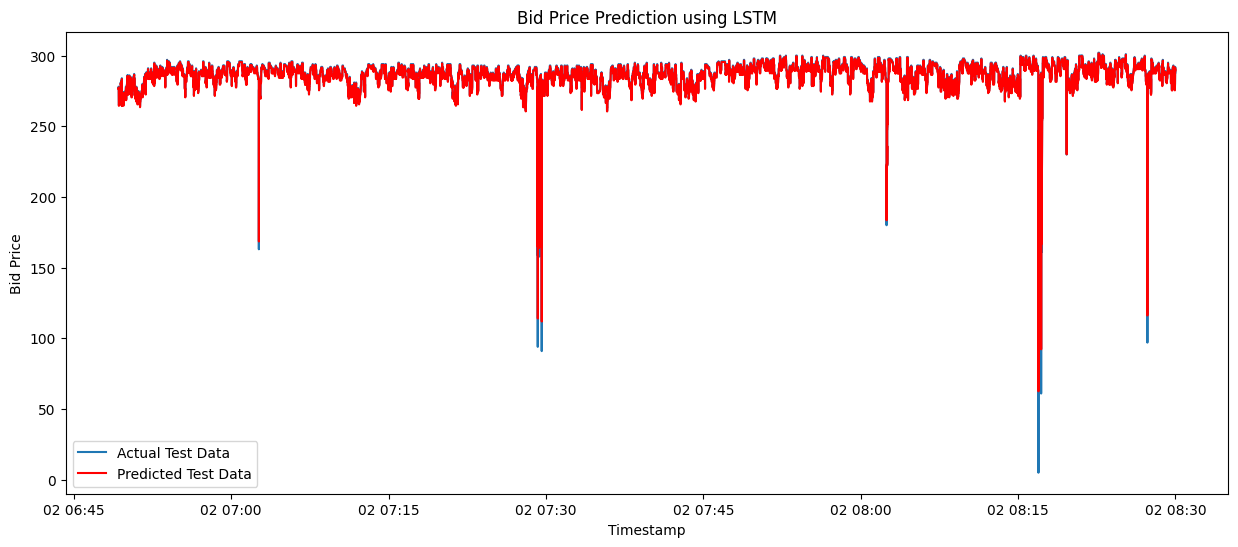

In [14]:
# Plotting
plt.figure(figsize=(15, 6))

# Use the timestamp range corresponding to the test data for x-axis
timestamps = data.index[train_size+look_back:train_size+look_back+len(testPredict)]

plt.plot(timestamps, testY_inv[0], label='Actual Test Data')
plt.plot(timestamps, testPredict.flatten(), label='Predicted Test Data', color='red')
plt.legend()
plt.title('Bid Price Prediction using LSTM')
plt.xlabel('Timestamp')
plt.ylabel('Bid Price')
plt.show()

